In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install mmWrt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from os.path import abspath, join, pardir
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from numpy import where, expand_dims


from mmWrt.Raytracing import rt_points  # noqa: E402
from mmWrt.Scene import Radar, Transmitter, Receiver, Target  # noqa: E402
from mmWrt import RadarSignalProcessing as rsp  # noqa: E402

32
(32, 42)


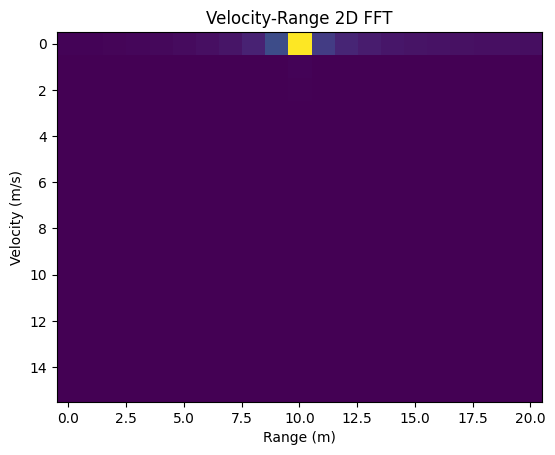

In [ ]:
from scipy.fft import fft, fft2
from numpy import sin, pi
c = 3e8

debug_ON = True
test = 0
NC=32
NA=64
radar = Radar(transmitter=Transmitter(bw=0.3e9, slope=70e8,
                                      t_interchirp=1.2e-6,
                                      chirps_count=NC),
              receiver=Receiver(fs=1e3, max_adc_buffer_size=256,
                                debug=debug_ON), debug=debug_ON)

target1 = Target(2)
"""
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4035586/
This movement ranges from 4–12 mm17 with a frequency range of 0.2–0.34 Hz (12–20 breaths per minute)18.
In addition to respiratory motion, the chest surface motion also includes comparatively faster but weaker vibrations (precordial motion41)
due to the beating of the heart. The chest surface motion due to the beating of the heart has an amplitude range of 0.2–0.5 mm19 and frequency range of 1–1.34 Hz
(60–80 beats per minute)18.
"""
fb = 0.2 #Hz
ab = 8e-3
fh = 1.15 #Hz
ah = 0.3e-3
target2 = Target(5, 0, 0, vx=lambda t: ab*sin(2*pi*fb*t)+ah*sin(2*pi*fh*t))

targets = [target2]

bb = rt_points(radar, targets, debug=debug_ON)
print(bb["chirps_count"])
cube = bb["adc_cube"][0,:,0,0,:]
print(cube.shape)
Z_fft2 = abs(fft2(cube))
Data_fft2 = Z_fft2  # [0:n_chirps//2,0:n_samples//2]

plt.xlabel("Range (m)")
plt.ylabel("Velocity (m/s)")
plt.title('Velocity-Range 2D FFT')
plt.imshow(Data_fft2[0:NC//2,0:42//2])

$$ y_{IF}(t) \approx cos(2 \pi \cdot [f_{0min} \cdot \delta + s \cdot \delta \cdot t ])$$

Where:

* $ f_{0min} $ the starting frequency of the chirp
* s is the slope of the chirp
* $\delta $ is the total time of flight between antennas and target

$$ \delta(t) = 2 \cdot \frac{R0 + m \cdot sin(\omega_m \cdot t)}{c} $$

Where:

* R0: main distance of target
* m: amplitude of vibration
* $\omega_m$: frequency of vibration

$$ \forall l \in \mathbb{N} , l \in [ \,0, L] \, $$

Where:
* L is the number of chirps
* l the index of a given chirp
* $T_c$ the total time between the start of two chirps
* $t_c$ the time starting at 0 at the begining of the chirp

$$ \delta = \frac{2[R0 + m \cdot sin(\omega_m \cdot [l \cdot T_c + t_c])]}{c} $$

considering that
$$ sin(\omega_m \cdot [l \cdot T_c + t_c]) = sin( \omega_m \cdot l \cdot T_c)cos(\omega_m \cdot t_c) + cos(\omega_m \cdot l \cdot T_c)sin(\omega_m \cdot t_c) $$

considering that $$ \omega_m \cdot t_c \approx 0 $$
$$ sin(\omega_m \cdot [l \cdot T_c + t_c]) \approx sin( \omega_m \cdot l \cdot T_c) $$

Thus
$$ \delta \approx \frac{2[R0 + m \cdot sin( \omega_m \cdot l \cdot T_c)]}{c} $$



In [ ]:
from numpy import arange, zeros

n_adc = 1024
n_chirps = 64
n_frames = 64

ts = 1e-2
fs = 1/ts


T = arange(0, n_adc*ts, ts)
assert fs > 2* fh
assert fs > 2* fb
t_interchirp=1.2e-6
fc = 1/t_interchirp
t_interframe = 1e-1
ff = 1/(t_interframe)
print(fb, fs/n_adc)
assert fb > fs/n_adc
assert fb > ff/n_frames
assert fh > ff/n_frames
assert int(ff/fb) != int(fh/fb)
n_tx = 1
n_rx = 1
adc_cube_2 = zeros((n_frames, n_chirps, n_tx, n_rx, n_adc))
tx_i=0
rx_i=0

for frame_i in range(n_frames):
    T[:] += t_interframe
    for chirp_i in range(n_chirps):
        T[:] += t_interchirp
        chest = lambda t: ab*sin(2*pi*fb*t)+ah*sin(2*pi*fh*t)
        YIF = chest(T)
        adc_cube_2[frame_i, chirp_i, tx_i, rx_i, :] = YIF
print(adc_cube_2.shape)

0.2 0.09765625
(64, 64, 1, 1, 1024)


(1024,)


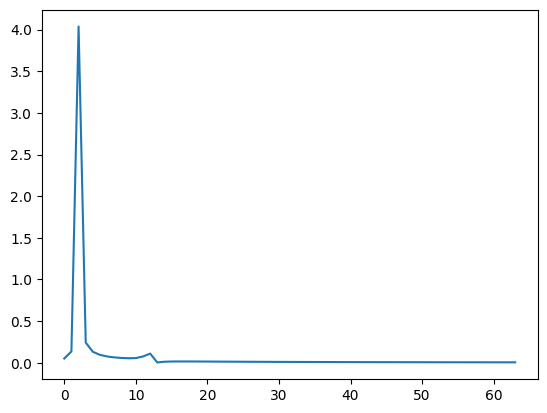

In [ ]:
cube = adc_cube_2[0,0,0,0,:]
print(cube.shape)
Z_fft = abs(fft(cube))
plt.plot(Z_fft[0:64])

(64, 64)


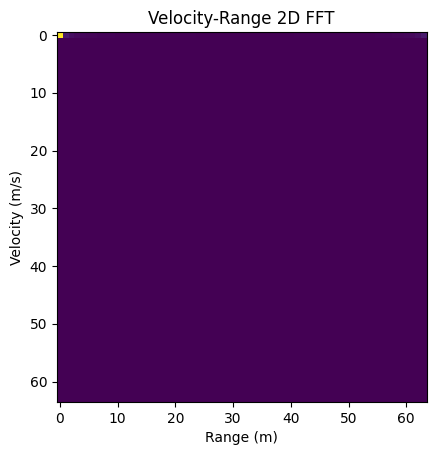

In [ ]:
cube = adc_cube_2[0,:,0,0,:]
print(cube.shape)
Z_fft2 = abs(fft2(cube))
Data_fft2 = Z_fft2  # [0:n_chirps//2,0:n_samples//2]

plt.xlabel("Range (m)")
plt.ylabel("Velocity (m/s)")
plt.title('Velocity-Range 2D FFT')
plt.imshow(Data_fft2)